In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import xgboost as xgb
import gymnasium as gym
import gym_trading_env
from stable_baselines3.common.env_util import make_vec_env

import warnings
warnings.filterwarnings("ignore")


In [2]:
ticker = 'NFLX'

# Training data periods
date_start = "2014-01-01"
date_end = "2023-12-31"

# Test data periods
test_start = "2024-01-01"
test_end = "2025-03-29"


In [3]:
# Download training data
daily_data = yf.download(ticker, start=date_start, end=date_end)

# Check column types
print("Training data columns:", daily_data.columns)


daily_data.columns = daily_data.columns.droplevel(1)

# Rename to lowercase
daily_data = daily_data.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'})


# Download test data
test_daily_data = yf.download(ticker, start=test_start, end=test_end)

# Check column types
print("Test data columns:", test_daily_data.columns)

test_daily_data.columns = test_daily_data.columns.droplevel(1)

# Rename to lowercase
test_daily_data = test_daily_data.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'})



YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Training data columns: MultiIndex([( 'Close', 'NFLX'),
            (  'High', 'NFLX'),
            (   'Low', 'NFLX'),
            (  'Open', 'NFLX'),
            ('Volume', 'NFLX')],
           names=['Price', 'Ticker'])
Test data columns: MultiIndex([( 'Close', 'NFLX'),
            (  'High', 'NFLX'),
            (   'Low', 'NFLX'),
            (  'Open', 'NFLX'),
            ('Volume', 'NFLX')],
           names=['Price', 'Ticker'])


In [4]:
daily_data.head()

Price,close,high,low,open,volume
Date,,,,,
2014-01-02,51.831429,52.511429,51.542858,52.401428,12325600
2014-01-03,51.871429,52.495712,51.842857,52.000000,10817100
2014-01-06,51.367142,52.044285,50.475716,51.889999,15501500
2014-01-07,48.500000,49.698570,48.152859,49.684284,36167600
2014-01-08,48.712856,49.425713,48.074287,48.104286,20001100


In [5]:
def preprocess(df):
    # Log transform volume
    df['volume'] = np.log1p(df['volume'])
    
    # # Technical indicators
    # df['sma_10'] = ta.trend.sma_indicator(df['close_nflx'], window=10)
    # df['sma_20'] = ta.trend.sma_indicator(df['close_nflx'], window=20)
    # df['ema_10'] = ta.trend.ema_indicator(df['close_nflx'], window=10)
    # df['rsi'] = ta.momentum.rsi(df['close_nflx'], window=14)
    
    
    # # MACD
    # macd = ta.trend.MACD(close=df['close_nflx'])
    # df['macd'] = macd.macd()
    # df['macd_signal'] = macd.macd_signal()
    # df['macd_diff'] = macd.macd_diff()
    

    # Feature engineering (matching RL file)
    df["feature_close"] = df["close"].pct_change()
    df["feature_open"] = df["open"]/df["close"].shift(1)
    df["feature_high"] = df["high"]/df["close"]
    df["feature_low"] = df["low"]/df["close"]
    
    return df.dropna()


In [6]:
daily_data = preprocess(daily_data)
test_daily_data = preprocess(test_daily_data)

In [7]:
daily_data

Price,close,high,low,open,volume,feature_close,feature_open,feature_high,feature_low
Date,,,,,,,,,
2014-01-03,51.871429,52.495712,51.842857,52.000000,16.196639,0.000772,1.003252,1.012035,0.999449
2014-01-06,51.367142,52.044285,50.475716,51.889999,16.556447,-0.009722,1.000358,1.013182,0.982646
2014-01-07,48.500000,49.698570,48.152859,49.684284,17.403674,-0.055817,0.967239,1.024713,0.992842
2014-01-08,48.712856,49.425713,48.074287,48.104286,16.811298,0.004389,0.991841,1.014634,0.986891
2014-01-09,48.150002,49.139999,47.857143,48.824287,16.649147,-0.011555,1.002288,1.020561,0.993918
...,...,...,...,...,...,...,...,...,...
2023-12-22,486.760010,496.019989,485.450012,494.000000,14.809170,-0.009865,1.004862,1.019024,0.997309
2023-12-26,491.190002,491.480011,486.380005,489.390015,14.525761,0.009101,1.005403,1.000590,0.990207
2023-12-27,491.790009,494.019989,489.250000,491.239990,14.756026,0.001222,1.000102,1.004534,0.994835


In [8]:
def build_lstm_trading_model(data, window_size=60, epochs=30, batch_size=16):
    """Build and train LSTM model for predicting price movements"""
    
    # Prepare features and target
    # Target: Binary signal (1 if price goes up, 0 if it goes down)
    data['target'] = (data['close'].shift(-1) > data['close']).astype(int)
    
    # Select features
    feature_columns = ['close', 'volume', 
                       'feature_close', 'feature_open', 'feature_high', 'feature_low']
    
    features = data[feature_columns]
    target = data['target']
    
    # Scale features
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(features)
    
    # Create sequences
    X, y = [], []
    for i in range(window_size, len(scaled_features)):
        X.append(scaled_features[i-window_size:i])
        y.append(target.iloc[i])
    
    X, y = np.array(X), np.array(y)
    
    # Split into training and validation sets
    split = int(len(X) * 0.8)
    X_train, X_val = X[:split], X[split:]
    y_train, y_val = y[:split], y[split:]
    
    # Build LSTM model for classification
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(window_size, len(feature_columns))))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=1
    )
    
    return model, scaler, feature_columns, window_size

In [9]:
def build_xgboost_trading_model(data):
    """Build and train XGBoost model for predicting price movements"""
    
    # Create target: 1 for price up, 0 for price down
    data['target'] = (data['close'].shift(-1) > data['close']).astype(int)
    
    # Select features (same as used in LSTM)
    feature_columns = ['close', 'volume', 
                       'feature_close', 'feature_open', 'feature_high', 'feature_low']
    
    X = data[feature_columns]
    y = data['target']
    
    # Train-val split
    split = int(len(X) * 0.8)
    X_train, X_val = X[:split], X[split:]
    y_train, y_val = y[:split], y[split:]
    
    # Build model
    model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.05,
        objective='binary:logistic',
        random_state=42
    )
    
    # Train model
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=True
    )
    
    return model, feature_columns

In [10]:
class MLTradingStrategy:
    """A trading strategy class that converts ML predictions into trading decisions"""
    
    def __init__(self, model_type, model, features, scaler=None, window_size=None, feature_index_map=None):
        self.model_type = model_type  # 'lstm' or 'xgboost'
        self.model = model
        self.features = features
        self.scaler = scaler
        self.window_size = window_size
        self.history = []
        self.feature_index_map = feature_index_map  # NEW: added for indexing features
    
    def predict_action(self, observation):
        """
        Convert observation to a trading action:
        - 0: Short (-1)
        - 1: Neutral (0)
        - 2: Long (1)
        """
        
        # === Extract features using index map ===
        if self.feature_index_map is None:
            raise ValueError("feature_index_map must be provided to use this strategy.")
        
        features = np.array([[observation[self.feature_index_map[f]] for f in self.features]])
        
        if self.model_type == 'lstm':
            # Add to history
            self.history.append(features[0])  # Flatten the 2D row for history
            
            if len(self.history) > self.window_size:
                self.history.pop(0)
            
            # Not enough history → stay neutral
            if len(self.history) < self.window_size:
                return 1  # Neutral
            
            # Prepare LSTM input: (1, window_size, num_features)
            input_data = np.array(self.history)
            input_data = self.scaler.transform(input_data)
            input_data = np.expand_dims(input_data, axis=0)
            
            prediction = self.model.predict(input_data)[0][0]
        
        elif self.model_type == 'xgboost':
            prediction = self.model.predict_proba(features)[0][1]
        
        else:
            raise ValueError(f"Unsupported model type: {self.model_type}")

        # === Map prediction to action ===
        if prediction > 0.67:
            return 2  # Long (1)
        elif prediction < 0.33:
            return 0  # Short (-1)
        else:
            return 1  # Neutral (0)


In [11]:
def evaluate_ml_strategy(strategy, env, num_episodes=10, initial_capital=1000):
    """Evaluate ML trading strategy using detailed metrics like RL evaluation."""
    representative_portfolio = []
    total_profits = []
    cumulative_returns = []
    sharpe_ratios = []
    max_drawdowns_pct = []
    max_drawdowns_dollar = []
    total_trades_list = []
    win_rates = []
    profitable_steps = []
    volatilities = []

    for _ in range(num_episodes):
        portfolio_values = []
        obs, info = env.reset()
        done = False
        truncated = False
        
        strategy.history = []
        portfolio_values = []
        rewards = []
        steps = 0
        wins = 0
        trades = 0
        initial_price = None

        while not done and not truncated:
            action = strategy.predict_action(obs)
            obs, reward, done, truncated, info = env.step(action)
            
            portfolio_val = info['portfolio_valuation']
            portfolio_values.append(portfolio_val)
            rewards.append(reward)

            if _ == 0:
                representative_portfolio = portfolio_values

            if initial_price is None:
                initial_price = info['data_close']

            if reward > 0:
                wins += 1
            if action != 0:
                trades += 1

            steps += 1

        # === Metrics ===
        start_val = portfolio_values[0]
        end_val = portfolio_values[-1]
        profit = end_val - start_val
        cumulative_return = (profit / start_val) * 100
        sharpe_ratio = np.mean(rewards) / np.std(rewards) if np.std(rewards) > 0 else 0
        max_drawdown = max(portfolio_values) - min(portfolio_values)
        max_drawdown_pct = (min(portfolio_values) / max(portfolio_values) - 1) * 100 if max(portfolio_values) > 0 else 0
        win_rate = (wins / steps) * 100 if steps > 0 else 0
        volatility = np.std(rewards)

        # === Store ===
        total_profits.append(profit)
        cumulative_returns.append(cumulative_return)
        sharpe_ratios.append(sharpe_ratio)
        max_drawdowns_dollar.append(max_drawdown)
        max_drawdowns_pct.append(max_drawdown_pct)
        total_trades_list.append(trades)
        profitable_steps.append(wins)
        win_rates.append(win_rate)
        volatilities.append(volatility)

    # === Return Aggregated Metrics ===
    return {
        "Total Profit ($)": np.mean(total_profits),
        "Cumulative Return (%)": np.mean(cumulative_returns),
        "Sharpe Ratio": np.mean(sharpe_ratios),
        "Max Drawdown ($)": np.mean(max_drawdowns_dollar),
        "Max Drawdown (%)": np.mean(max_drawdowns_pct),
        "Total Trades": np.mean(total_trades_list),
        "Profitable Steps": np.mean(profitable_steps),
        "Win Rate (%)": np.mean(win_rates),
        "Volatility": np.mean(volatilities),
        "Representative Portfolio": representative_portfolio
    }


In [12]:
print("Training ML models for trading...")

# -------------- Train LSTM ---------------
print("\n1. Training LSTM model...")
lstm_model, lstm_scaler, lstm_features, window_size = build_lstm_trading_model(daily_data)



Training ML models for trading...

1. Training LSTM model...
Epoch 1/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.5045 - loss: 0.6953 - val_accuracy: 0.4949 - val_loss: 0.6938
Epoch 2/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.5005 - loss: 0.6937 - val_accuracy: 0.4949 - val_loss: 0.6943
Epoch 3/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.5278 - loss: 0.6919 - val_accuracy: 0.4949 - val_loss: 0.6976
Epoch 4/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.5303 - loss: 0.6918 - val_accuracy: 0.4949 - val_loss: 0.6932
Epoch 5/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.4761 - loss: 0.6937 - val_accuracy: 0.4949 - val_loss: 0.6931
Epoch 6/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.5143 - loss: 0.6930 - val_accuracy: 0.4949 - val_loss: 0.6934
Epoch 7/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.5084 - loss: 0.6933 - val_accuracy: 0.4949 - val_loss: 0.6938
Epoch 8/30
123/123 ━━━━━━━━━━━━━━━━━

In [13]:
# -------------- Train XGBoost ---------------
print("\n2. Training XGBoost model...")
xgb_model, xgb_features = build_xgboost_trading_model(daily_data)


2. Training XGBoost model...
[0]	validation_0-logloss:0.69423
[1]	validation_0-logloss:0.69453
[2]	validation_0-logloss:0.69493
[3]	validation_0-logloss:0.69532
[4]	validation_0-logloss:0.69566
[5]	validation_0-logloss:0.69572
[6]	validation_0-logloss:0.69545
[7]	validation_0-logloss:0.69560
[8]	validation_0-logloss:0.69592
[9]	validation_0-logloss:0.69594
[10]	validation_0-logloss:0.69616
[11]	validation_0-logloss:0.69677
[12]	validation_0-logloss:0.69695
[13]	validation_0-logloss:0.69733
[14]	validation_0-logloss:0.69750
[15]	validation_0-logloss:0.69776
[16]	validation_0-logloss:0.69756
[17]	validation_0-logloss:0.69791
[18]	validation_0-logloss:0.69774
[19]	validation_0-logloss:0.69818
[20]	validation_0-logloss:0.69853
[21]	validation_0-logloss:0.69896
[22]	validation_0-logloss:0.69922
[23]	validation_0-logloss:0.69974
[24]	validation_0-logloss:0.70029
[25]	validation_0-logloss:0.70080
[26]	validation_0-logloss:0.70104
[27]	validation_0-logloss:0.70106
[28]	validation_0-logloss:0.

In [14]:
# -------------- Create Trading Environment ---------------
print("\n3. Setting up trading environment for evaluation...")
test_env = gym.make("TradingEnv",
    name="Netflix_USD",
    df=test_daily_data,
    positions=[-1, 0, 1],  # -1 (=SHORT), 0(=OUT), +1 (=LONG)
    trading_fees=0.005/100,  # 0.005% per stock buy/sell (Binance fees)
    borrow_interest_rate=0.0001/100,  # 0.0001% per timestep (one timestep = 1h here)
)



3. Setting up trading environment for evaluation...


In [22]:

# -------------- Evaluate LSTM Strategy ---------------
print("\n4. Evaluating LSTM trading strategy...")
lstm_feature_index_map = {feature: idx for idx, feature in enumerate(lstm_features)}
lstm_strategy = MLTradingStrategy(
    model_type='lstm',
    model=lstm_model,
    features=lstm_features,
    scaler=lstm_scaler,
    window_size=window_size,
    feature_index_map=lstm_feature_index_map
)
lstm_results = evaluate_ml_strategy(lstm_strategy, test_env)
portfolio_values_LSTM = lstm_model["Representative Portfolio"]


4. Evaluating LSTM trading strategy...


UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names

In [23]:


plt.figure(figsize=(12, 5))
plt.plot(portfolio_values_LSTM, label='Portfolio Value')
plt.title("Portfolio Value Over Time")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'portfolio_values_LSTM' is not defined

<Figure size 1200x500 with 0 Axes>

In [31]:

# -------------- Evaluate XGBoost Strategy ---------------
print("\n5. Evaluating XGBoost trading strategy...")
xgb_feature_index_map = {feature: idx for idx, feature in enumerate(xgb_features)}
xgb_strategy = MLTradingStrategy(
    model_type='xgboost',
    model=xgb_model,
    features=xgb_features,
    feature_index_map=xgb_feature_index_map
)

xgb_results = evaluate_ml_strategy(xgb_strategy, test_env)



5. Evaluating XGBoost trading strategy...
Market Return : 98.58%   |   Portfolio Return : 51.74%   |   
Market Return : 98.58%   |   Portfolio Return : 51.74%   |   
Market Return : 98.58%   |   Portfolio Return : 26.88%   |   
Market Return : 98.58%   |   Portfolio Return : 26.89%   |   
Market Return : 98.58%   |   Portfolio Return : 51.74%   |   
Market Return : 98.58%   |   Portfolio Return : 26.88%   |   
Market Return : 98.58%   |   Portfolio Return : 51.74%   |   
Market Return : 98.58%   |   Portfolio Return : 26.88%   |   
Market Return : 98.58%   |   Portfolio Return : 51.74%   |   
Market Return : 98.58%   |   Portfolio Return : 26.89%   |   


In [32]:

# -------------- Comparison ---------------
print("\n6. Comparing ML trading strategies:")
results = {
    "LSTM": lstm_results,
    "XGBoost": xgb_results
}



6. Comparing ML trading strategies:


In [34]:

# Convert to DataFrame for easier comparison
results_df = pd.DataFrame(results)
print(results_df)

                             LSTM     XGBoost
Total Profit ($)         0.000000  388.495262
Cumulative Return (%)    0.000000   38.731284
Sharpe Ratio            -0.028490    0.074160
Max Drawdown ($)         0.000000  518.190225
Max Drawdown (%)         0.000000  -34.113950
Total Trades           309.000000  309.000000
Profitable Steps         0.000000   81.000000
Win Rate (%)             0.000000   26.213592
Volatility               0.000001    0.014054


In [37]:
results_df.to_csv("results.csv")

In [65]:

from stable_baselines3 import DQN , PPO , A2C
from stable_baselines3.common.evaluation import evaluate_policy

# Environments 

In [66]:
env = gym.make("TradingEnv",
    name="Netflix_USD",
    df=daily_data,
    positions=[-1, 0, 1],
    trading_fees=0.005/100,
    borrow_interest_rate=0.0001/100,
    windows=60
)

In [67]:
test_env = gym.make("TradingEnv",
    name="Netflix_USD",
    df=test_daily_data,
    positions=[-1, 0, 1],
    trading_fees=0.005/100,
    borrow_interest_rate=0.0001/100,
    windows=60
)

In [68]:
def evaluate_policy_with_metrics(model, env, render=False, plot=True):
    obs, _ = env.reset()
    terminated, truncated = False, False

    rewards = []
    portfolio_values = []
    actions = []

    # Capture initial portfolio value manually
    initial_value = env._portfolio.valorisation(env._get_price())
    portfolio_values.append(initial_value)

    while not (terminated or truncated):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)

        rewards.append(reward)
        actions.append(action)

        # Use info dict if it has portfolio_value, else fallback
        if "portfolio_value" in info:
            portfolio_values.append(info["portfolio_value"])
        else:
            try:
                current_value = env._portfolio.valorisation(env._get_price())
                portfolio_values.append(current_value)
            except:
                pass  # Skip appending if price fetch fails (edge case)

        if render:
            env.render()

    if len(portfolio_values) < 2:
        print("⚠️ Not enough portfolio values recorded to compute metrics.")
        return {}

    portfolio_values = np.array(portfolio_values)
    returns = np.diff(portfolio_values) / portfolio_values[:-1]
    actions = np.array(actions)

    total_profit = portfolio_values[-1] - portfolio_values[0]
    cumulative_return_pct = (portfolio_values[-1] / portfolio_values[0] - 1) * 100
    sharpe_ratio = np.mean(returns) / (np.std(returns) + 1e-9) * np.sqrt(252)
    max_drawdown = np.max(np.maximum.accumulate(portfolio_values) - portfolio_values)
    max_drawdown_pct = (max_drawdown / np.max(np.maximum.accumulate(portfolio_values))) * 100

    profitable_steps = sum(np.array(rewards) > 0)
    total_trades = np.sum(actions != 0)
    win_rate = profitable_steps / len(rewards)

    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(portfolio_values, label='Portfolio Value')
        plt.title("Portfolio Value Over Time")
        plt.xlabel("Time Step")
        plt.ylabel("Portfolio Value ($)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    results = {
        "Total Profit ($)": total_profit,
        "Cumulative Return (%)": cumulative_return_pct,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown ($)": max_drawdown,
        "Max Drawdown (%)": max_drawdown_pct,
        "Total Trades": int(total_trades),
        "Profitable Steps": int(profitable_steps),
        "Win Rate (%)": win_rate * 100
    }

    return results



In [ ]:


# Evaluation on train   
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=1)
print(f"DQN Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")


# DQN Model

In [69]:


model = DQN("MlpPolicy", env, verbose=1, tensorboard_log="./dqn_tensorboard/")
model.learn(total_timesteps=100_000)

model.save("dqn_trading_model")

# Evaluation on train
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=1)
print(f"DQN Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./dqn_tensorboard/DQN_2
Market Return : 868.14%   |   Portfolio Return : -72.94%   |   
Market Return : 868.14%   |   Portfolio Return : -89.26%   |   
Market Return : 868.14%   |   Portfolio Return : -64.70%   |   
Market Return : 868.14%   |   Portfolio Return : -92.56%   |   
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.46e+03 |
|    ep_rew_mean      | -1.79    |
|    exploration_rate | 0.0671   |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1446     |
|    time_elapsed     | 6        |
|    total_timesteps  | 9820     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000238 |
|    n_updates        | 2429     |
----------------------------------
Market Return : 868.14%   |   Portfolio Return : -41.52%   |   
Market Return : 868.14%   

Market Return : 53.76%   |   Portfolio Return : 24.06%   |   


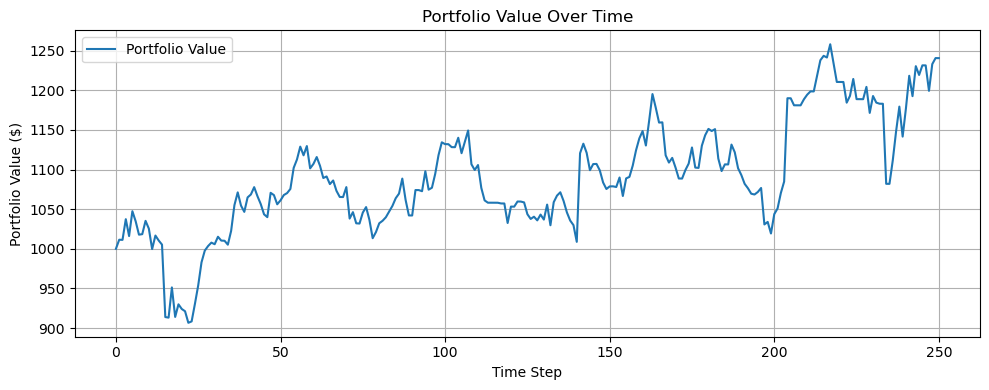

Total Profit ($): 240.63
Cumulative Return (%): 24.06
Sharpe Ratio: 0.86
Max Drawdown ($): 176.17
Max Drawdown (%): 14.00
Total Trades: 203.00
Profitable Steps: 121.00
Win Rate (%): 48.40


In [70]:
# Load trained model
model = DQN.load("dqn_trading_model")

# Evaluate
metrics = evaluate_policy_with_metrics(model, test_env)
for k, v in metrics.items():
    print(f"{k}: {v:.2f}")

In [71]:
# STEP 6: Train PPO
ppo_model = PPO("MlpPolicy", env, verbose=1, tensorboard_log="./ppo_logs/")
ppo_model.learn(total_timesteps=100_000)
ppo_model.save("ppo_trading_model")

# STEP 7: Train A2C
a2c_model = A2C("MlpPolicy", env, verbose=1, tensorboard_log="./a2c_logs/")
a2c_model.learn(total_timesteps=100_000)
a2c_model.save("a2c_trading_model")




Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./ppo_logs/PPO_1
-----------------------------
| time/              |      |
|    fps             | 1535 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
Market Return : 868.14%   |   Portfolio Return : 51.84%   |   
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.46e+03    |
|    ep_rew_mean          | 0.418       |
| time/                   |             |
|    fps                  | 1162        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012569732 |
|    clip_fraction        | 0.0859      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_va


📈 PPO Evaluation:
Market Return : 53.76%   |   Portfolio Return : 53.76%   |   


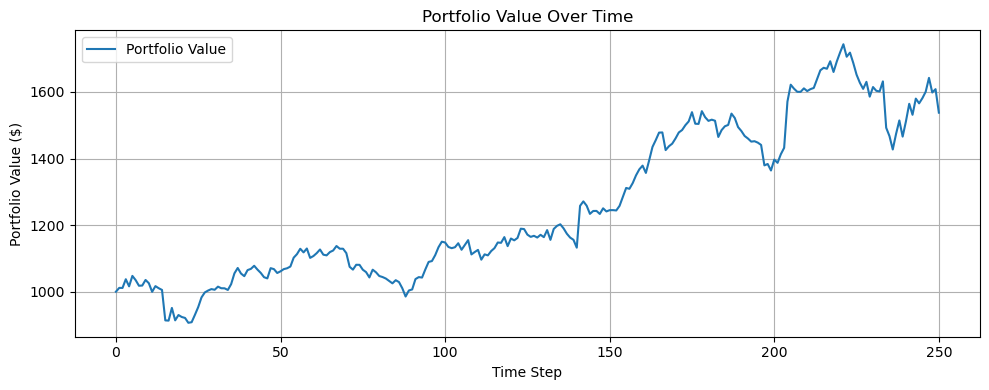

Total Profit ($): 537.63
Cumulative Return (%): 53.76
Sharpe Ratio: 1.52
Max Drawdown ($): 316.01
Max Drawdown (%): 18.13
Total Trades: 250.00
Profitable Steps: 133.00
Win Rate (%): 53.20

📉 A2C Evaluation:
Market Return : 53.76%   |   Portfolio Return : 53.75%   |   


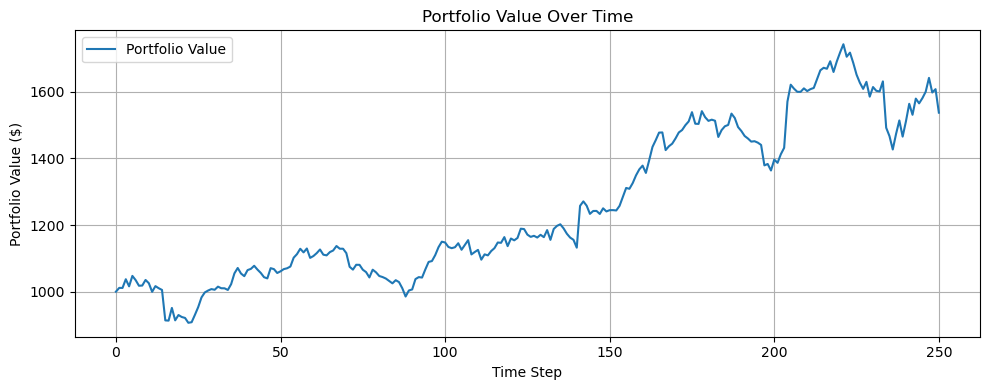

Total Profit ($): 537.48
Cumulative Return (%): 53.75
Sharpe Ratio: 1.52
Max Drawdown ($): 315.97
Max Drawdown (%): 18.13
Total Trades: 250.00
Profitable Steps: 133.00
Win Rate (%): 53.20


In [72]:
# STEP 8: Evaluate PPO
print("\n📈 PPO Evaluation:")
ppo_model = PPO.load("ppo_trading_model")
ppo_metrics = evaluate_policy_with_metrics(ppo_model, test_env)
for k, v in ppo_metrics.items():
    print(f"{k}: {v:.2f}")

# STEP 9: Evaluate A2C
print("\n📉 A2C Evaluation:")
a2c_model = A2C.load("a2c_trading_model")
a2c_metrics = evaluate_policy_with_metrics(a2c_model, test_env)
for k, v in a2c_metrics.items():
    print(f"{k}: {v:.2f}")